In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import torch
import matplotlib.colors as mcolors
from tqdm import tqdm

# Add parent directory to system path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core and utils directory 
from algorithms import OnlineMA, OnlineMARegret
from load_utils import cdf_from_quantiles
from utils import rolling_mean, rolling_vec_norm

In [3]:
raw_data_folder = './raw_data'
quantiles_folder = './woAR'

# Map quantiles_i.csv to Task j
MAP = {i: i+4 for i in range(1, 12)}

def load_raw_task(task_num):
    if task_num == 15:
        # special case for solution to task 15 files 
        solution_load_path = os.path.join(raw_data_folder, 'Solution to Task 15', 'solution15_L.csv')
        solution_temp_path = os.path.join(raw_data_folder, 'Solution to Task 15', 'solution15_L_temperature.csv')
        data_load = pd.read_csv(solution_load_path)
        data_temp = pd.read_csv(solution_temp_path)
        data_temp['TEMP_AVG'] = data_temp[['w3','w9']].mean(axis=1)
        out = pd.DataFrame({
            'LOAD': data_temp['LOAD'],
            'TEMP_AVG': data_temp['TEMP_AVG']
        })
        return out.reset_index(drop=True)
    # Task 4-14
    task_solution_path = os.path.join(raw_data_folder, f'Task {task_num}', f'L{task_num}-train.csv')
    df = pd.read_csv(task_solution_path)
    df = df[df['LOAD'].notna()].copy()
    df['TEMP_AVG'] = df[['w3','w9']].mean(axis=1)
    return df[['LOAD','TEMP_AVG']].reset_index(drop=True)

# Align quantiles with raw task data
aligned = []
for i in range(1, 13):
    quantiles_path = os.path.join(quantiles_folder, f'quantiles_{i}.csv')
    quantiles_df = pd.read_csv(quantiles_path)
    quantiles = quantiles_df.values  # (T, 99)
    if i == 12:
        raw_df = load_raw_task(15)
    else:
        raw_df = load_raw_task(MAP[i])
    T = min(len(raw_df), len(quantiles))
    raw_df = raw_df.iloc[:T].reset_index(drop=True)
    quantiles = quantiles[:T, :]
   
    # Build baseline p_tilde = P(LOAD >= c)
    c = 150.0
    p_tilde = 1 - np.array([cdf_from_quantiles(q_row)(c -1e-9) for q_row in quantiles], dtype=float)

    y_t = (raw_df['LOAD'].values >= c).astype(float)

    # Temperature bin groups [-inf,20],(20,40],...,[80,inf)
    bins = [-np.inf, 20, 40, 60, 80, np.inf]
    g_idx = pd.cut(raw_df['TEMP_AVG'], bins=bins, right=True, include_lowest=True, labels=False).astype(int)
    num_groups = len(bins) - 1
    g_mat = np.eye(num_groups, dtype=float)[g_idx]
  
    aligned.append({
        'file_idx': i,
        'num_groups': num_groups,
        'y': y_t,
        'g_mat': g_mat,
        'p_tilde': p_tilde,
    })

y_all = np.concatenate([hourly['y'] for hourly in aligned], axis=0)
p_all = np.concatenate([hourly['p_tilde'] for hourly in aligned], axis=0)
g_all = np.vstack([hourly['g_mat'] for hourly in aligned])

print({'T_total': len(y_all), 'groups': g_all.shape[1],})


{'T_total': 8760, 'groups': 5}


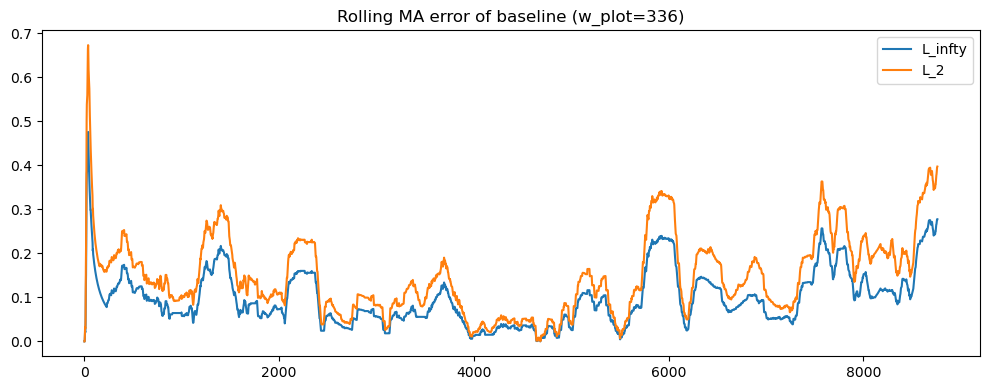

In [4]:
# Plot MA error of baseline
vec_ptilde = (g_all * (y_all - p_all)[:, None])  # (T, m)
vec_ptilde_pair = np.concatenate([vec_ptilde, -vec_ptilde], axis=1)

window_plot = 336
baseline_ma_linf = rolling_vec_norm(vec_ptilde_pair, window_plot, norm="l_infty")
baseline_ma_l2 = rolling_vec_norm(vec_ptilde_pair, window_plot, norm="l2")
plt.figure(figsize=(10,4))
plt.plot(baseline_ma_linf, label='L_infty')
plt.plot(baseline_ma_l2, label='L_2')
plt.legend(); plt.title(f'Rolling MA error of baseline (w_plot={window_plot})'); plt.tight_layout(); plt.show()


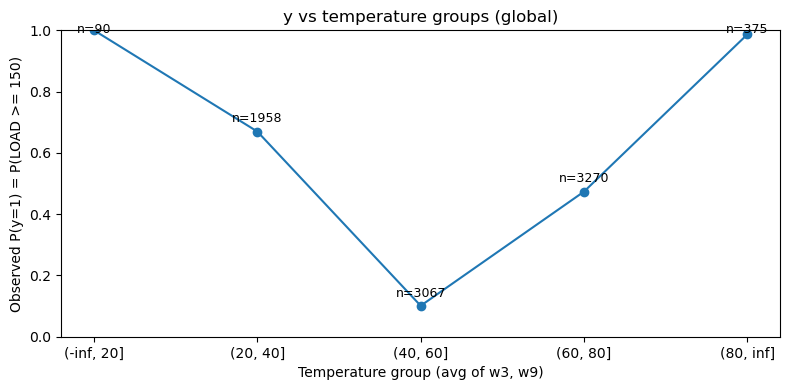

In [ ]:
# Plot observed P(y=1) vs temperature groups (global trend)
m = g_all.shape[1]
labels = ['(-inf, 20]', '(20, 40]', '(40, 60]', '(60, 80]', '(80, inf]']

# Recover group index from one-hot
group_idx_all = g_all.argmax(axis=1)

df_yg = pd.DataFrame({'group': group_idx_all, 'y': y_all})
means = df_yg.groupby('group')['y'].mean().reindex(range(m)).values
counts = df_yg.groupby('group')['y'].size().reindex(range(m)).fillna(0).astype(int).values

plt.figure(figsize=(8, 4))
plt.plot(range(m), means, marker='o')
plt.xticks(range(m), labels, rotation=0)
plt.ylabel('Observed P(y=1) = P(LOAD >= 150)')
plt.xlabel('Temperature group (avg of w3, w9)')
plt.title('y vs temperature groups (global)')

# Annotate group counts
for i, (mu, n) in enumerate(zip(means, counts)):
    plt.text(i, min(max(mu + 0.02, 0.02), 0.98), f'n={n}', ha='center', va='bottom', fontsize=9)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [11]:
window = 336
window_plot = 336
eta = 0.5
loss = "log"

# Build arrays for 0..T-1
T = len(y_all)
X = np.ones((T, 1), dtype=float)
G = g_all.astype(float)
num_groups = G.shape[1]

# Online learners 
maonly = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
maonly_nonadaptive = OnlineMA(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)
mareg = OnlineMARegret(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss)
mareg_nonadaptive = OnlineMARegret(d=X.shape[1], m=num_groups, eta=eta, window_size=window, gamma_pred=0.0, loss=loss, num_time_steps=T, adaptive=False)

# Track metrics
ptilde_baseline_ma_losses = [] 
maonly_baseline_ma_losses, maonly_baseline_lreg = [], []
maonly_nonadaptive_ma_losses, maonly_nonadaptive_lreg = [], []
mareg_ma_losses, mareg_l_reg = [], []
mareg_nonadaptive_ma_losses, mareg_nonadaptive_l_reg = [], []

for t in tqdm(range(T)):
    x_t = X[t]                  # (1,)
    y_t_scalar = float(y_all[t])
    g_t = G[t]                  # (m,)
    pt_t = float(p_all[t])

    # Baseline from p̃: MA vector at step t
    vec_ptilde_t = g_t * (y_t_scalar - pt_t)   # (m,)
    ptilde_baseline_ma_losses.append(np.concatenate([vec_ptilde_t, -vec_ptilde_t]))

    # Baseline: MA-only baseline (no regret term)
    metrics = maonly.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    maonly_baseline_ma_losses.append(metrics["ma_losses"])  
    maonly_baseline_lreg.append(metrics["l_reg"])           

    # Baseline: Non-adaptive MA-only
    metrics = maonly_nonadaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    maonly_nonadaptive_ma_losses.append(metrics["ma_losses"])  
    maonly_nonadaptive_lreg.append(metrics["l_reg"])           

    # Baseline: Non-adaptive MA+Reg
    metrics = mareg_nonadaptive.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    mareg_nonadaptive_ma_losses.append(metrics["ma_losses"])   
    mareg_nonadaptive_l_reg.append(metrics["l_reg"])           

    # Model update: MA+Reg with adaptive \eta
    metrics = mareg.update(x_t, y_t_scalar, g_t, p_tilde=pt_t)
    mareg_ma_losses.append(metrics["ma_losses"])               
    mareg_l_reg.append(metrics["l_reg"])                       

ptilde_baseline_ma_l2 = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l2")
ptilde_baseline_ma_linf = rolling_vec_norm(ptilde_baseline_ma_losses, window_plot, norm="l_infty")
maonly_baseline_ma_l2 = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l2")
maonly_baseline_ma_linf = rolling_vec_norm(maonly_baseline_ma_losses, window_plot, norm="l_infty")
maonly_baseline_lreg = rolling_mean(maonly_baseline_lreg, window_plot)
maonly_nonadaptive_ma_l2 = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l2")
maonly_nonadaptive_ma_linf = rolling_vec_norm(maonly_nonadaptive_ma_losses, window_plot, norm="l_infty")
maonly_nonadaptive_lreg = rolling_mean(maonly_nonadaptive_lreg, window_plot)
mareg_nonadaptive_ma_l2 = rolling_vec_norm(mareg_nonadaptive_ma_losses, window_plot, norm="l2")
mareg_nonadaptive_ma_linf = rolling_vec_norm(mareg_nonadaptive_ma_losses, window_plot, norm="l_infty")
mareg_nonadaptive_l_reg = rolling_mean(mareg_nonadaptive_l_reg, window_plot)
mareg_ma_l2 = rolling_vec_norm(mareg_ma_losses, window_plot, norm="l2")
mareg_ma_linf = rolling_vec_norm(mareg_ma_losses, window_plot, norm="l_infty")
mareg_lreg = rolling_mean(mareg_l_reg, window_plot)


100%|██████████| 8760/8760 [05:43<00:00, 25.52it/s]


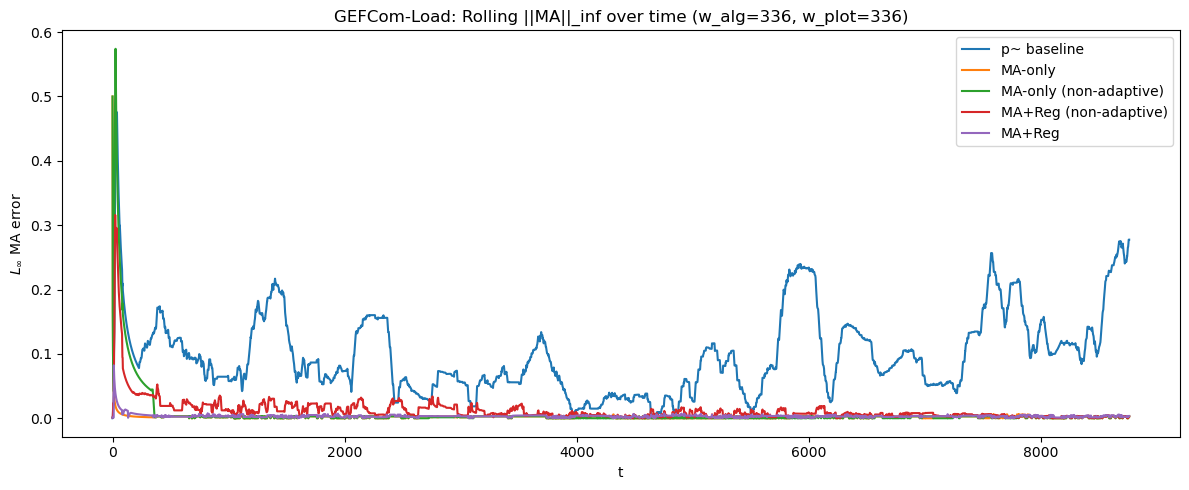

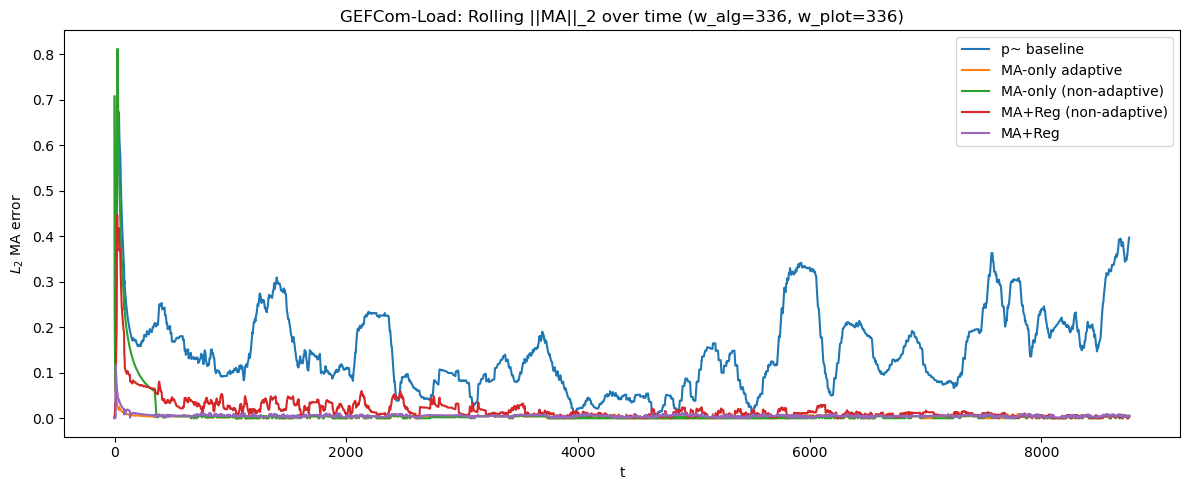

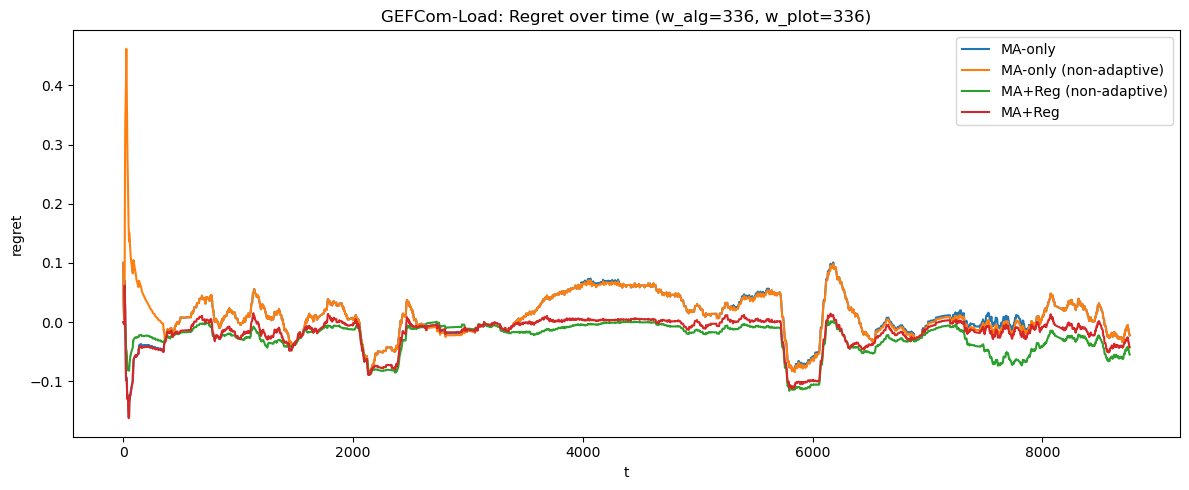

In [14]:
# Plot L_infty
plt.figure(figsize=(12, 5))
plt.plot(ptilde_baseline_ma_linf, label='p~ baseline')
plt.plot(maonly_baseline_ma_linf, label='MA-only')
plt.plot(maonly_nonadaptive_ma_linf, label='MA-only (non-adaptive)')
plt.plot(mareg_nonadaptive_ma_linf, label='MA+Reg (non-adaptive)')
plt.plot(mareg_ma_linf, label='MA+Reg')
plt.xlabel("t")
plt.ylabel(r"$L_\infty$ MA error")
plt.title(f"GEFCom-Load: Rolling ||MA||_inf over time (w_alg={window}, w_plot={window_plot})")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot L2
plt.figure(figsize=(12, 5))
plt.plot(ptilde_baseline_ma_l2, label='p~ baseline')
plt.plot(maonly_baseline_ma_l2, label='MA-only adaptive')
plt.plot(maonly_nonadaptive_ma_l2, label='MA-only (non-adaptive)')
plt.plot(mareg_nonadaptive_ma_l2, label='MA+Reg (non-adaptive)')
plt.plot(mareg_ma_l2, label='MA+Reg')
plt.xlabel("t")
plt.ylabel(r"$L_2$ MA error")
plt.title(f"GEFCom-Load: Rolling ||MA||_2 over time (w_alg={window}, w_plot={window_plot})")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot L_reg 
plt.figure(figsize=(12, 5))
plt.plot(maonly_baseline_lreg, label='MA-only')
plt.plot(maonly_nonadaptive_lreg, label='MA-only (non-adaptive)')
plt.plot(mareg_nonadaptive_l_reg, label='MA+Reg (non-adaptive)')
plt.plot(mareg_lreg, label='MA+Reg')
plt.xlabel("t")
plt.ylabel("regret")
plt.title(f"GEFCom-Load: Regret over time (w_alg={window}, w_plot={window_plot})")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


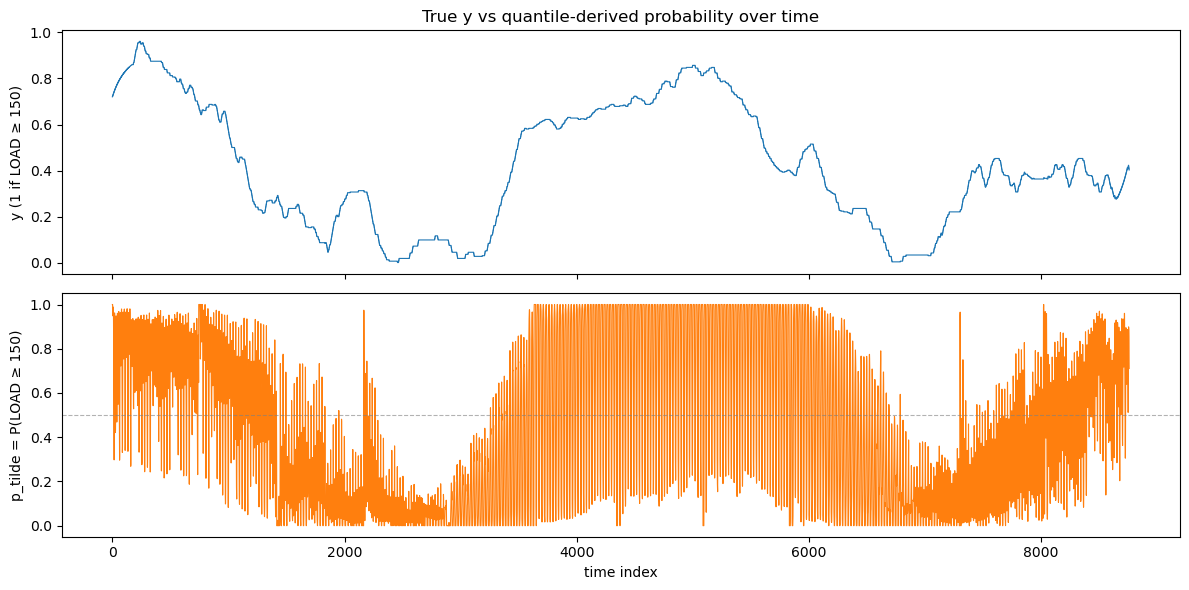

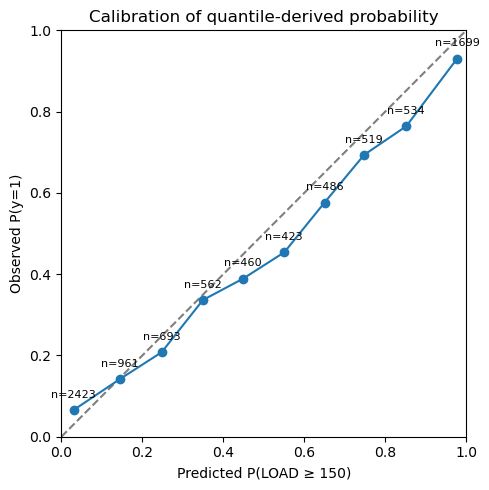

In [8]:
# Compare quantile-derived probabilities to true y
T = len(y_all)
df_combined = pd.DataFrame({
    't': np.arange(T),
    'y': y_all.astype(float),
    'p_tilde': p_all.astype(float),
})

df_combined['y_rolling'] = df_combined['y'].rolling(window=window_plot, center=True, min_periods=1).mean()

# Plot both time-series 
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(df_combined['t'], df_combined['y_rolling'], drawstyle='steps-post', color='tab:blue', linewidth=0.8)
axes[0].set_ylabel('y (1 if LOAD ≥ 150)')
axes[0].set_title('True y vs quantile-derived probability over time')

axes[1].plot(df_combined['t'], df_combined['p_tilde'], color='tab:orange', linewidth=0.8)
axes[1].set_ylabel('p_tilde = P(LOAD ≥ 150)')
axes[1].set_xlabel('time index')
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.6, linewidth=0.8)
plt.tight_layout()
plt.show()

# Calibration plot: observed P(y=1) vs predicted p_tilde bins
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)
df_combined['bin'] = pd.cut(df_combined['p_tilde'], bins=bins, include_lowest=True)
cal = df_combined.groupby('bin', observed=True).agg(pred=('p_tilde','mean'), obs=('y','mean'), n=('y','size'))

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--', alpha=0.5)
plt.plot(cal['pred'], cal['obs'], marker='o')
for i, (px, oy, n) in enumerate(zip(cal['pred'], cal['obs'], cal['n'])):
    plt.text(px, min(max(oy + 0.03, 0.03), 0.97), f'n={int(n)}', ha='center', fontsize=8)
plt.xlabel('Predicted P(LOAD ≥ 150)')
plt.ylabel('Observed P(y=1)')
plt.title('Calibration of quantile-derived probability')
plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()
plt.show()
